<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment02/PCD_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

##

Implementing following program from scratch

1. Convolution Function

2. Spatial Filtering with several kernel and discuss in which image case the kernel is suitable for

3. Sharpening with blurring operation

4. Make discussion in the end of COLAB, in which case the filtering should be used instead of pixel-based method.

Create your notebook with name as "PCD_Assignment02" and upload to GitHub. You need to provide your GitHub's code link to the text editor in submission form.

## Import

In [3]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

PCD  sample_data
fatal: destination path 'PCD' already exists and is not an empty directory.
PCD  sample_data


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
import copy

## function==============================================================================================================

### Kernel

#### Custom Kernel
$Sebarang\ matriks\ berbentuk\ berikut:$

$ K̇\begin{bmatrix}
c_{1,1} & c_{1,2} & \dots & c_{1,n} \\
c_{2,1} & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & c_{n-1,n} \\
c_{n,1} & \dots & c_{n,n-1} & c_{n,n}
\end{bmatrix}$

In [5]:
kernel_identitas = np.array([[0,0,0],[0,1,0],[0,0,0]]) #kernel identitas, konvolusi dengan citra menghasilkan citra itu sendiri

kernel_avg3x3 = np.array([[1,1,1],[1,1,1],[1,1,1]])*(1/9) #kernel averaging ukuran 3x3 atau averaging filter untuk smoothing/blurring

kernel_shiftL = np.array([[0,0,0],[1,0,0],[0,0,0]]) #kernel shift, menggeser citra
kernel_shiftR = np.array([[0,0,0],[0,0,1],[0,0,0]]) #kernel shift, menggeser citra
kernel_shiftD = np.array([[0,1,0],[0,0,0],[0,0,0]]) #kernel shift, menggeser citra
kernel_shiftU = np.array([[0,0,0],[0,0,0],[1,0,0]]) #kernel shift, menggeser citra


#### Averaging Kernel (Smoothing Kernel)

$M_{N\times N} \ adalah \ matriks \ kernel \ averaging  $

$M_{N\times N} = \frac{1}{\sum_{i=1}^{n} \sum_{j=1}^{n} c_{i,j}} \begin{bmatrix}
c_{1,1} & c_{1,2} & \dots & c_{1,n} \\
c_{2,1} & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & c_{n-1,n} \\
c_{n,1} & \dots & c_{n,n-1} & c_{n,n}
\end{bmatrix};\ c_{i,j}=1,\ ∀i,j \in N=\{1,2,3,...,n\}$


In [6]:
#membuat averaging kernel (smoothing kernel) ukuran nxn
def avg_kernel(size):
  kernel = np.ones((size, size), dtype=float) / (size * size)
  # kernel = np.ones((size, size), dtype=int) / (size * size)
  return kernel

#### Gaussian Kernel

$Matriks\ kernel\ berisi\ nilai\ yang\ terdistribusi\ secara\ normal \\
 dengan\ pusat\ distribusi\ pada\ elemen\ indeks\ (0,0)\ dan\ K\ suatu\ konstanta  $

$ K̇\begin{bmatrix}
e^{-\frac{(-n/2)^2+(n/2)^2}{2\sigma^2}} &  & \dots & e^{-\frac{0^2+(n/2)^2}{2\sigma^2}} & \dots & & e^{-\frac{(n/2)^2+(n/2)^2}{2\sigma^2}} \\
\vdots &  & \ddots & \vdots & .^{.^{.}} & & \vdots  \\
 &  & e^{-\frac{(-1)^2+1^2}{2\sigma^2}} & e^{-\frac{0^2+1^2}{2\sigma^2}} & e^{-\frac{1^2+1^2}{2\sigma^2}} & & \vdots  \\
e^{-\frac{(-n/2)^2+0^2}{2\sigma^2}} & \dots & e^{-\frac{(-1)^2+0^2}{2\sigma^2}} & e^{-\frac{0^2+0^2}{2\sigma^2}} & e^{-\frac{1^2+0^2}{2\sigma^2}} & \dots & e^{-\frac{(n/2)^2+0^2}{2\sigma^2}} \\
 & & e^{-\frac{(-1)^2+(-1)^2}{2\sigma^2}} & e^{-\frac{0^2+(-1)^2}{2\sigma^2}} & e^{-\frac{1^2+(-1)^2}{2\sigma^2}} &  & \vdots \\
\vdots & &.^{.^{.}} & \vdots & \ddots &  & \vdots \\
e^{-\frac{(-n/2)^2+(-n/2)^2}{2\sigma^2}} &  & \dots & e^{-\frac{0^2+(-n/2)^2}{2\sigma^2}} & \dots &  & e^{-\frac{(n/2)^2+(-n/2)^2}{2\sigma^2}}
\end{bmatrix}$

In [7]:
def gaussian_kernel(size, sigma, muu):
  # X, Y  grid f kernel size
  X, Y = np.meshgrid(np.linspace(-1, 1, size),
                      np.linspace(-1, 1, size))
  jarakXY = np.sqrt((X**2) + (Y**2))

  K = 1
  gauss = np.exp(-((jarakXY - muu)**2 / (2.0 * sigma**2)))*K

  normal_constant = 1/(np.sum(gauss))
  # print(np.sum(gauss))
  # print(gauss)

  for i in range(gauss.shape[0]):
    for j in range(gauss.shape[1]):
      # print(gauss[i,j],np.sum(gauss))
      gauss[i][j] = gauss[i][j]*normal_constant

  return gauss
  # return gauss, normal_constant

# gaussian = gaussian_kernel(3,1,0)
# print(gaussian[0])
# print(gaussian[0]*gaussian[1])

#### Sharpening Kernel (Sharpening with blurring operation)

$\begin{align*}
F + α(F-F*H) &= F*I + α(F*I - F*H) \\
             &= F + αF(I - H) \\
             &= F*( I + α(I - H)) \\
             &= F*( I + αI - αH) \\
             &= F*((1+\alpha)I - \alpha H) \\
             &= F*H_{baru}
\end{align*}$

$keterangan:$

$\begin{align*}
  F &= matriks\, citra\, ; \\  
  α &=skalar\, ; \\
  I_{n\times n} &= a_{ij} \begin{cases} \mbox{1,} & \mbox{jika }\, i=j=⌈n/2⌉ \\ \mbox{0,} & \mbox{lainnya } \end{cases}\, ; \\  
  H &= matriks\, kernel\, blurring\, ; \\
  H_{baru} &= matriks\, kernel\, sharpening.
\end{align*}$


$\\ $

$Note:\ (F-F*H)\ disebut\ sebagai\ mask$


In [8]:
def sharpening(alpha,kernel):

  size = kernel.shape[0]
  H = kernel
  I = np.zeros(shape=(size,size),dtype=float)
  I[size//2][size//2] = 1

  # sharperning_kernel = I-H
  sharperning_kernel = (1+alpha)*I - (alpha*H)
  # print(sharperning_kernel)

  return sharperning_kernel

#### Laplacian Kernel

$Kernel\ Laplace$

$ \begin{bmatrix}
0 & 1 & 0  \\
1 & -4 & 1 \\
0 & 1 & 0 \\
\end{bmatrix};\ \begin{bmatrix}
1 & 1 & 1  \\
1 & -8 & 1 \\
1 & 1 & 1 \\
\end{bmatrix};\ \begin{bmatrix}
0 & -1 & 0  \\
-1 & 4 & -1 \\
0 & -1 & 0 \\
\end{bmatrix};\ \begin{bmatrix}
-1 & -1 & -1  \\
-1 & 8 & -1 \\
-1 & -1 & -1 \\
\end{bmatrix}\ $

$Dibentuk\ persamaan\ :$


$\begin{align*}
 ∇^2f &= \frac{∂^2 f}{∂x^2}+\frac{∂^2 f}{∂y^2} \\
      &= f(x+1,y)+f(x-1,y)-2f(x,y)+f(x,y+1)+f(x,y-1)-2f(x,y) \\
      &= f(x+1,y)+f(x-1,y)+f(x,y+1)+f(x,y-1)-4f(x,y)
\end{align*}$

$   $

$\begin{bmatrix}
0 & f(x,y+1) & 0  \\
f(x-1,y) & f(x,y) & f(x+1,y) \\
0 & f(x,y-1) & 0 \\
\end{bmatrix}$


In [57]:
laplace1 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
laplace2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])

def sharpening_laplacian(img,a,laplaced):
  # output1 = img - (a*laplaced)
  # output = img + output1

  output = img + (a*laplaced)
  return output

### fungsi konvolusi

In [52]:
def konvolusi(img,kernel):

  ksize = kernel.shape[0]
  pad = ksize // 2
  kernel = np.flipud(np.fliplr(kernel))

  # padding
  padded = np.pad(img, pad, mode='constant')

  # hasil konvolusi
  output = np.zeros_like(img)

  for i in range(img.shape[0]):
      for j in range(img.shape[1]):
          region = padded[i:i+ksize, j:j+ksize]
          output[i, j] = np.sum(region * kernel)

  return output

In [53]:
def konvolusi_3channel(img,kernel):

  ksize = kernel.shape[0]
  pad = ksize // 2
  kernel = np.flipud(np.fliplr(kernel))

  output = np.zeros_like(img, dtype=float)
  # output = np.zeros_like(img, dtype=int)
  # output = np.zeros_like(img)

  for c in range(3):
      padded = np.pad(img[:,:,c], pad, mode='constant')
      for i in range(img.shape[0]):      # baris
          for j in range(img.shape[1]):  # kolom
              region = padded[i:i+ksize, j:j+ksize]
              val = float(np.sum(region * kernel))
              # val = int(np.sum(region * kernel))
              # val = np.sum(region * kernel)
              output[i, j, c] = val

  if np.min(output)<0:
    output = np.clip(output,0,1)

  # return output.astype(np.uint8)
  return output

##main=================================================================================================================

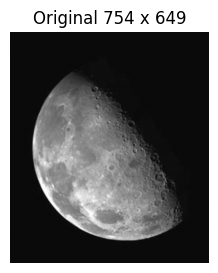

In [ ]:
# img_path = '/content/PCD/PCD_Assignment02/images/4x4colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/8x8colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/woman01.png'
# img_path = '/content/PCD/PCD_Assignment02/images/pattern.png'
img_path = '/content/PCD/PCD_Assignment02/images/moon.png'

img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = img_as_float(img)

# print(img.shape)
# print(img)

plt.figure(figsize=(10,3))
plt.imshow(img, cmap='gray')
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

In [ ]:
out1 = konvolusi(img, kernel_identitas)
out2 = konvolusi(img, kernel_avg3x3)
out3 = konvolusi(img, kernel_shiftL)
out4 = konvolusi(img, avg_kernel(5))
out5 = konvolusi(img, gaussian_kernel(11,1,0))
out6 = konvolusi(img, sharpening(1,avg_kernel(5)))
out7 = konvolusi(img, sharpening(1,gaussian_kernel(11,1,0)))
out8 = konvolusi(img, laplace1)
out9 = sharpening_laplacian(img, 1, out8)
out10 = konvolusi(img, laplace2)
out11 = sharpening_laplacian(img, 1, out10)

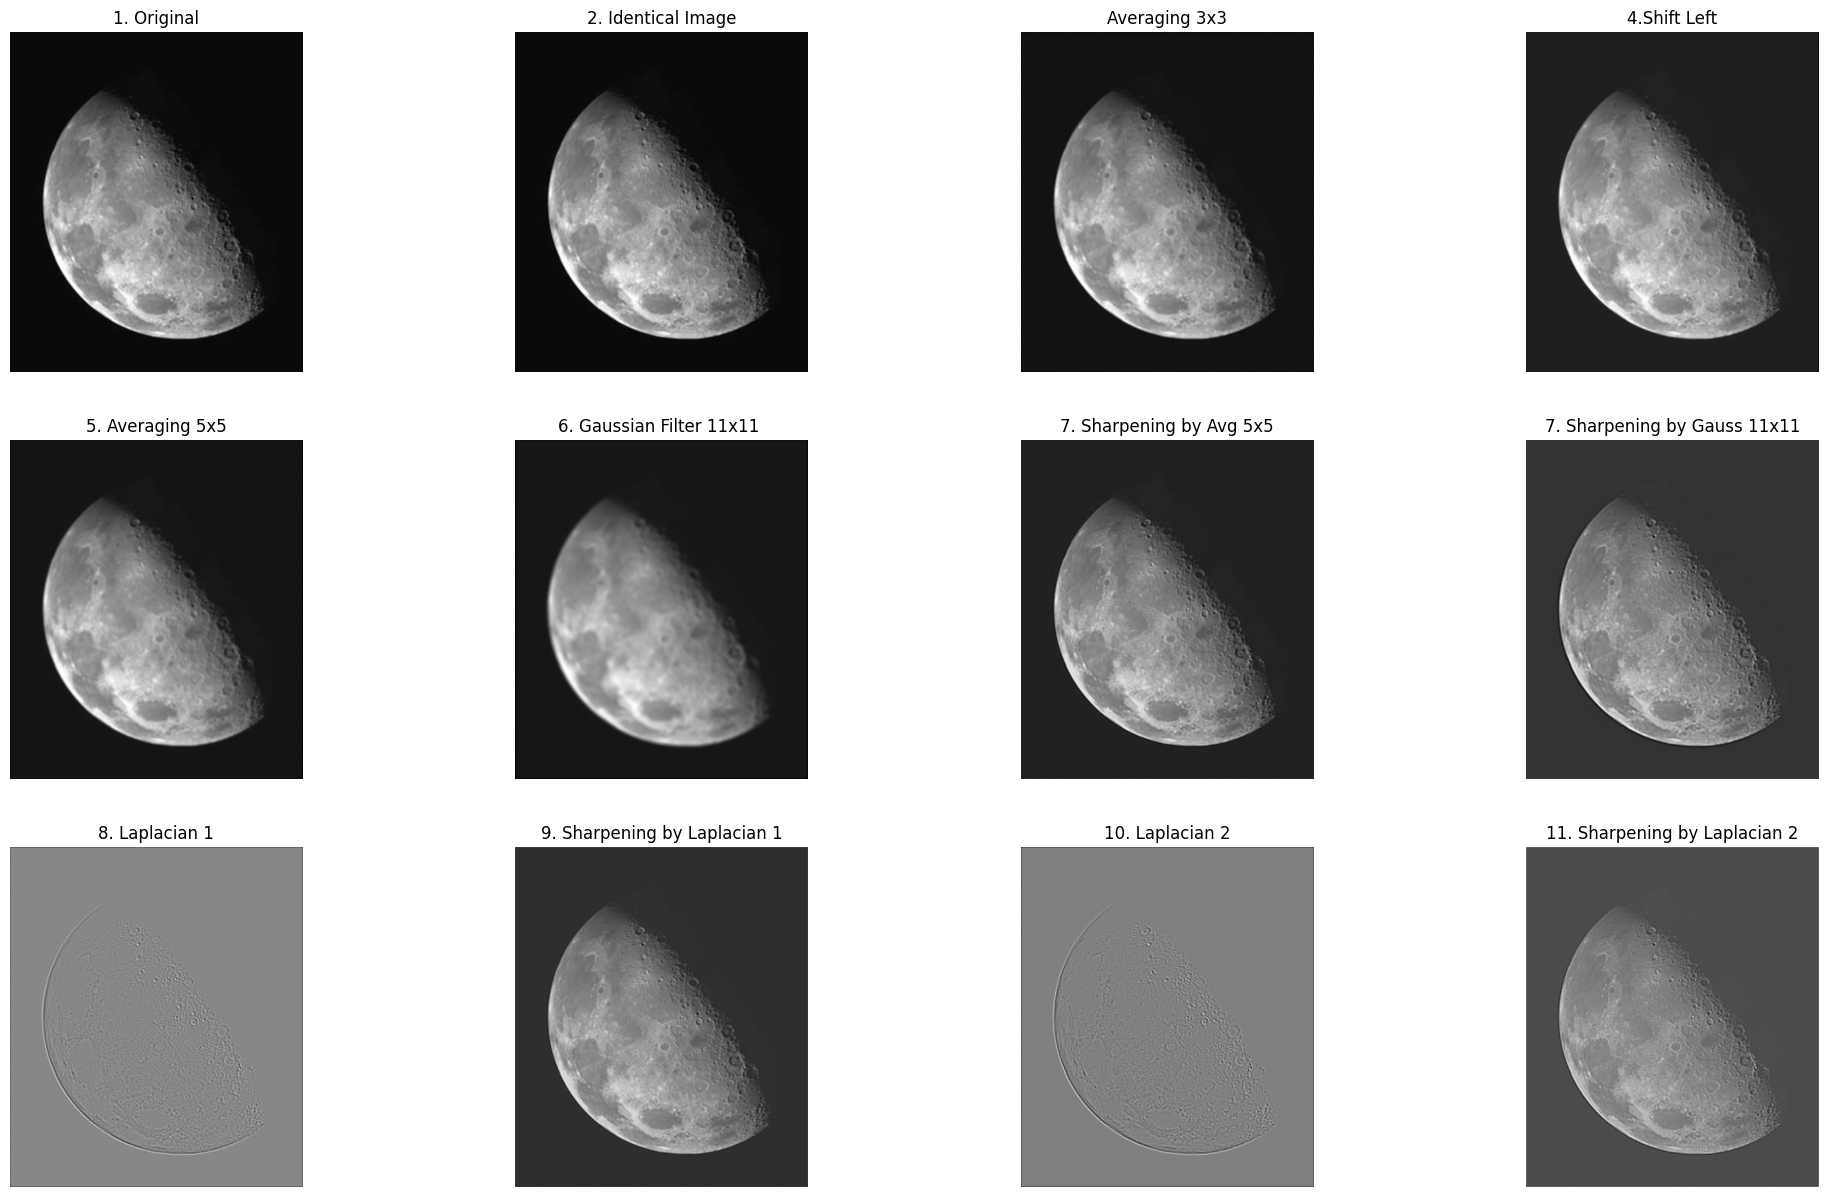

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(25,15))
ax[0,0].imshow(img, cmap='gray'); ax[0,0].set_title("1. Original"); ax[0,0].axis("off")
ax[0,1].imshow(out1, cmap='gray'); ax[0,1].set_title("2. Identical Image"); ax[0,1].axis("off")
ax[0,2].imshow(out2, cmap='gray'); ax[0,2].set_title("Averaging 3x3"); ax[0,2].axis("off")
ax[0,3].imshow(out3, cmap='gray'); ax[0,3].set_title("4.Shift Left"); ax[0,3].axis("off")
ax[1,0].imshow(out4, cmap='gray'); ax[1,0].set_title("5. Averaging 5x5"); ax[1,0].axis("off")
ax[1,1].imshow(out5, cmap='gray'); ax[1,1].set_title("6. Gaussian Filter 11x11 "); ax[1,1].axis("off")
ax[1,2].imshow(out6, cmap='gray'); ax[1,2].set_title("7. Sharpening by Avg 5x5"); ax[1,2].axis("off")
ax[1,3].imshow(out7, cmap='gray'); ax[1,3].set_title("7. Sharpening by Gauss 11x11"); ax[1,3].axis("off")
ax[2,0].imshow(out8, cmap='gray'); ax[2,0].set_title("8. Laplacian 1"); ax[2,0].axis("off")
ax[2,1].imshow(out9, cmap='gray'); ax[2,1].set_title("9. Sharpening by Laplacian 1"); ax[2,1].axis("off")
ax[2,2].imshow(out10, cmap='gray'); ax[2,2].set_title("10. Laplacian 2"); ax[2,2].axis("off")
ax[2,3].imshow(out11, cmap='gray'); ax[2,3].set_title("11. Sharpening by Laplacian 2"); ax[2,3].axis("off")
plt.show()

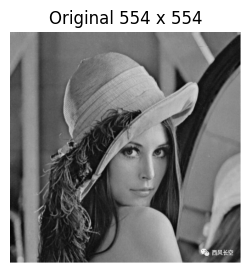

In [58]:
# img_path = '/content/PCD/PCD_Assignment02/images/4x4colour.jpg'
# img_path = '/content/PCD/PCD_Assignment02/images/8x8colour.jpg'
img_path = '/content/PCD/PCD_Assignment02/images/woman01.png'
# img_path = '/content/PCD/PCD_Assignment02/images/pattern.png'

img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = img_as_float(img)

# img = cv2.imread(img_path)
# # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img = img_as_float(img)

# print(img.shape)
# print(img)

plt.figure(figsize=(10,3))
plt.imshow(img, cmap='gray')
plt.title(f"Original {img.shape[0]} x {img.shape[1]}")
plt.axis("off")

plt.show()

In [61]:
out1 = konvolusi(img, kernel_identitas)
out2 = konvolusi(img, kernel_avg3x3)
out3 = konvolusi(img, kernel_shiftL)
out4 = konvolusi(img, avg_kernel(5))
out5 = konvolusi(img, gaussian_kernel(11,1,0))
# out5 = konvolusi_3channel(img, gaussian_kernel(11,1,0))
out6 = konvolusi(img, sharpening(1,avg_kernel(5)))
out7 = konvolusi(img, sharpening(1,gaussian_kernel(11,1,0)))
out8 = konvolusi(img, laplace1)
out9 = sharpening_laplacian(img, 1, out8)
out10 = konvolusi(img, laplace2)
out11 = sharpening_laplacian(img, 1, out10)

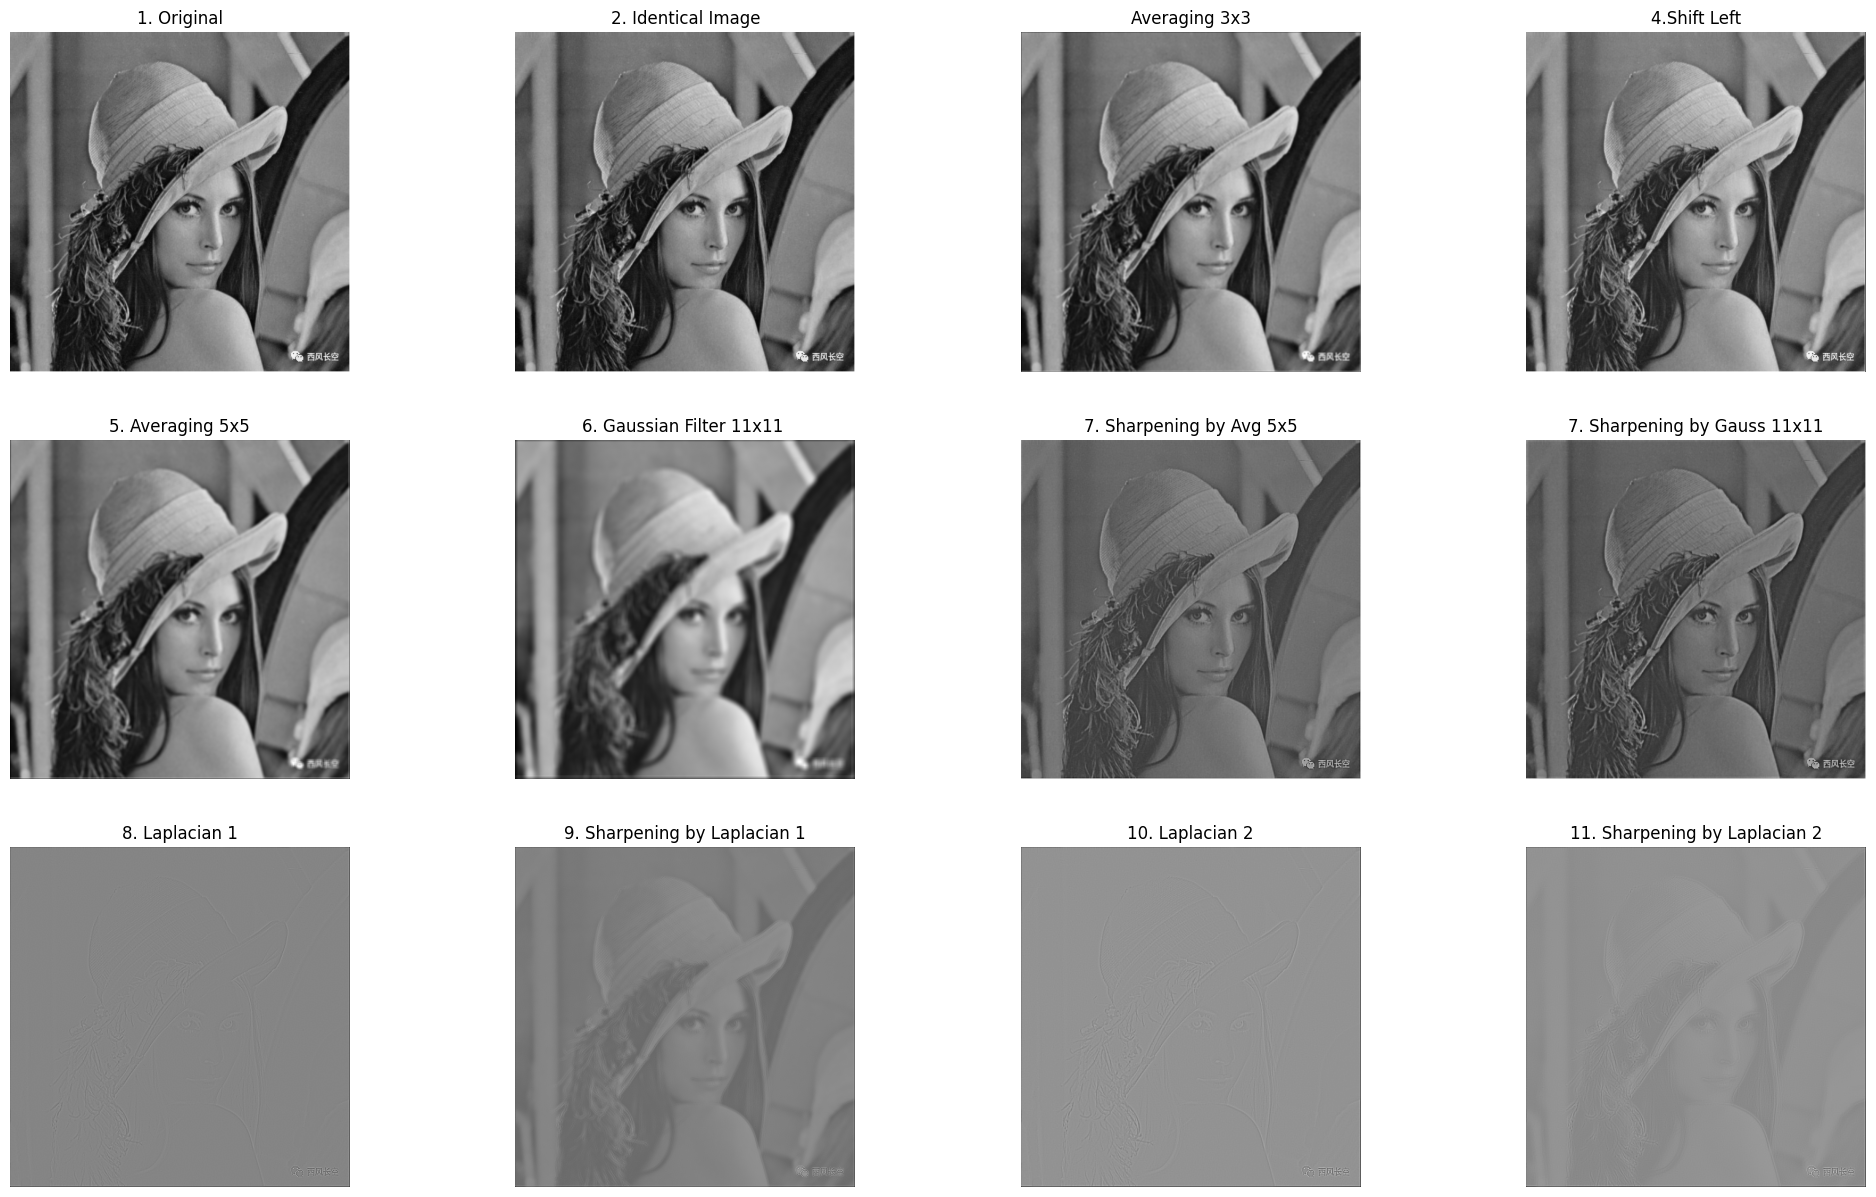

In [62]:
fig, ax = plt.subplots(3,4, figsize=(25,15))
ax[0,0].imshow(img, cmap='gray'); ax[0,0].set_title("1. Original"); ax[0,0].axis("off")
ax[0,1].imshow(out1, cmap='gray'); ax[0,1].set_title("2. Identical Image"); ax[0,1].axis("off")
ax[0,2].imshow(out2, cmap='gray'); ax[0,2].set_title("Averaging 3x3"); ax[0,2].axis("off")
ax[0,3].imshow(out3, cmap='gray'); ax[0,3].set_title("4.Shift Left"); ax[0,3].axis("off")
ax[1,0].imshow(out4, cmap='gray'); ax[1,0].set_title("5. Averaging 5x5"); ax[1,0].axis("off")
ax[1,1].imshow(out5, cmap='gray'); ax[1,1].set_title("6. Gaussian Filter 11x11 "); ax[1,1].axis("off")
ax[1,2].imshow(out6, cmap='gray'); ax[1,2].set_title("7. Sharpening by Avg 5x5"); ax[1,2].axis("off")
ax[1,3].imshow(out7, cmap='gray'); ax[1,3].set_title("7. Sharpening by Gauss 11x11"); ax[1,3].axis("off")
ax[2,0].imshow(out8, cmap='gray'); ax[2,0].set_title("8. Laplacian 1"); ax[2,0].axis("off")
ax[2,1].imshow(out9, cmap='gray'); ax[2,1].set_title("9. Sharpening by Laplacian 1"); ax[2,1].axis("off")
ax[2,2].imshow(out10, cmap='gray'); ax[2,2].set_title("10. Laplacian 2"); ax[2,2].axis("off")
ax[2,3].imshow(out11, cmap='gray'); ax[2,3].set_title("11. Sharpening by Laplacian 2"); ax[2,3].axis("off")
plt.show()

## Discussion

Pertanyaan utama: "Pada kasus apa/bagaimana filter spasial digunakan ketimbang metode berbasis pixel (non-spasial)?"

Contoh beberapa permasalahan kualitas citra seperti berikut:
1.   Gelap atau terang citra
2.   Tinggi rendahnya kontras citra
3.   Derau (noise) pada citra
4.   Tingkat ketajaman citra
5.   Resolusi rendah
6.   Keseimbangan warna

Dari permasalahan diatas, nomor 1 dan 2 diselesaikan dengan metode berbasis pixel (non-spasial) sedangkan no 3 sampai 6 cocok diselesaikan dengan metode spasial.

Kenapa masalah no 1 dan 2 cukup diselesaikan dengan metode berbasis pixel? dan yang lainnya dengan metode spasial?

Permasalahan no 1 merupakan permasalahan citra berdasar nilai pixel dari citra. Misalnya, suatu citra terlihat gelap karena kebanyakan intensitas pixel-pixelnya memiliki nilai cenderung dekat dengan 0 (Asumsi range nilai gray 8-bit yaitu 0-255, 0 berarti warna hitam/gelap sedangkan 255 putih/cerah) sehingga jika diinginkan citranya agar lebih cerah dapat dilakukan suatu metode transformasi pixel untuk mengubah seluruh nilai pixel citra menjadi lebih cerah jadi intensitas nilai pixel-pixel yang cenderung mendekati 0 atau gelap menjadi bernilai cenderung dekat dengan 255 atau tambah cerah. Transformasi ini bersifat global yaitu perubahan menyeluruh

Untuk masalah no. 2 juga mirip seperti no.1 hanya saja bukan soal gelap dan terang melainkan kontras dimana rendahnya kontras dari citra mengartikan intensitas nilai-nilai pixel dari citra memiliki range selisih nilai pixel terendah dengan pixel tertinggi cenderung kecil. Oleh karena itu, dapat dilakukan transformasi untuk mendistribusikan nilai-nilai pixel supaya range selisihnya membesar.

Jadi masalah no. 1 dan 2 diselesaikan menggunakan metode berbasis pixel karena transformasinya global sedangkan masalah lainnya menggunakan metode spasial.

Kenapa masalah 3 sampai 6 tidak diselesaikan dengan metode berbasis pixel?

Misalkan masalah no. 3 diselesaikan dengan metode pixel yaitu dengan mengubah nilai intensitas pixel dari citra sehingga semua nilai pixel berubah maka pixel yang dianggap sebagai noise juga berubah. Namun karena berubah secara menyeluruh atau global, citra masih memiliki noise karena noisenya ikut berubah tidak hilang dalam kata lain transformasi berbasis pixel hanya merubah nilai tiap pixel tanpa dipengaruhi pixel tetangga lainnya.

Maka dari itu digunakan metode spasial bersifat local yaitu transformasi nilai pixel yang mempertimbangkan nilai pixel tetangga. Pada masalah no. 3, pixel noise nilainya berubah menyesuaikan nilai pixel tetangganya yaitu pixel bukan noise, kemungkinan dilakukan averaging sehingga nilai pixel noise menjadi sama rata dengan nilai pixel tetangga. Begitu pula dengan masalah no.4 karena ketajaman dari citra terlalu tinggi menjadikan informasi pada citra terlalu banyak dan tidak perlu maka dapat dilakukan transformasi spasial dengan mengubah nilai sebagian pixel yang dikira tidak perlu menjadi rata dengan nilai pixel tetangganya.

Kesimpulannya metode atau filter spasial digunakan untuk kasus permasalahan yang membutuhkan transformasi local atau sebagian dari citra dimana perubahan nilai pixelnya dipengaruhi nilai pixel tetangga.



